# Classification Pipeline

In [44]:
%reload_ext autoreload
%autoreload 3

from pathlib import Path
import scipy.stats as st

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.model_selection import GroupShuffleSplit, StratifiedGroupKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.svm import LinearSVC, SVC
from src.sugnet.pipeline import extract_features

from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import TSNE


In [51]:
CV = GroupShuffleSplit(n_splits=200, test_size=0.2)
CHANCE_CV = GroupShuffleSplit(n_splits=200, test_size=0.2)
n_permutations = 100
output_path = Path('data/classification_output')

In [3]:
# 1. Data
DATA = pd.read_csv('docs/plb_hyp_data_long.csv', index_col=0)

# clean unwanted observations
DATA = DATA.query('description == "hypnosis"')
DATA = DATA.query('condition.str.contains("experience")')


DATA = DATA.query('bids_id <= 50')
DATA['bids_id'] = DATA['bids_id'].apply(lambda x: str(x).rjust(2, '0'))

#Xy
X = DATA[['bids_id','procedure']].values
y = DATA['hypnosis_depth'].apply(lambda x: 0 if x <= 5 else 1).values
groups = DATA['bids_id']

In [69]:
# 2. PIPELINE
pipe = Pipeline([
    ('extract', FunctionTransformer(extract_features, kw_args={'kind': 'power sensor',
                                                               'frequency_band': 'beta'})),
    ('zerovar', VarianceThreshold(threshold=0.0)),
    ('scale', StandardScaler()),
    # ('pca', PCA(n_components=30)),
    # ('select', SelectFromModel(LinearSVC(penalty='l2', max_iter=100000, dual=False,))),
    # ('clf', LinearSVC(penalty='l2', max_iter=100000, dual=False)),
    ('select', SelectFromModel(SVC(kernel="linear", max_iter=100000))),
    ('clf', SVC(kernel="linear", max_iter=100000, probability=True)),
])
# DEBUG: pipe.fit(X, y).score(X, y)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipe, X, y, groups=groups, cv=CV, scoring='accuracy')
scores.mean(), scores.std(), st.bootstrap(scores.reshape(1, -1), np.mean)


(0.625,
 0.11937336386313321,
 BootstrapResult(confidence_interval=ConfidenceInterval(low=0.6080000000000001, high=0.64125), standard_error=0.008445756998221986))

In [5]:
grid_params = {
    'extract__kw_args': [
        dict(kind='correlation source'),
        dict(kind='correlation sensor'),
        dict(kind='power sensor'),
        dict(kind='power source'),
        dict(kind='plv source'),
    ]
}

from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(pipe, grid_params, cv=CV, scoring='accuracy', verbose=1)
grid.fit(X, y, groups=groups)


Fitting 100 folds for each of 5 candidates, totalling 500 fits


GridSearchCV(cv=GroupShuffleSplit(n_splits=100, random_state=None, test_size=0.2,
         train_size=None),
             estimator=Pipeline(steps=[('extract',
                                        FunctionTransformer(func=<function extract_features at 0x11ee9e4c0>,
                                                            kw_args={'kind': 'power '
                                                                             'source'})),
                                       ('zerovar', VarianceThreshold()),
                                       ('scale', StandardScaler()),
                                       ('select',
                                        SelectFromModel(estimator=LinearSVC(dual=False,
                                                                            max_iter=100000,
                                                                            penalty='l1'))),
                                       ('clf',
                                        Lin

In [6]:
# prepare grid results to plot
grid_results = pd.DataFrame(grid.cv_results_)
grid_results['label'] = grid_results['params'].apply(lambda p: list(p.values())[0]['kind'])

split_cols = [c for c in grid_results.columns if 'split' in c]

grid_results['test_score'] = grid_results[split_cols].apply(lambda x: list(x), axis=1)
grid_results.drop(columns=split_cols, inplace=True)
grid_results = grid_results.explode('test_score')


def fit_chance(model_name=None):
    """Utility function to simulate emperical chance level."""
    
    chance_model = DummyClassifier(strategy='most_frequent')
    chance_scores = cross_val_score(chance_model, X, y, groups=groups, cv=CHANCE_CV, scoring='accuracy')
    return chance_scores

chance_scores = {}
for model_name in grid_results['label'].unique():
    model_chance_scores = fit_chance(model_name)
    chance_scores[f'{model_name}'] = model_chance_scores.tolist()
    
chance_scores = pd.DataFrame(chance_scores).melt(var_name='label', value_name='test_score')

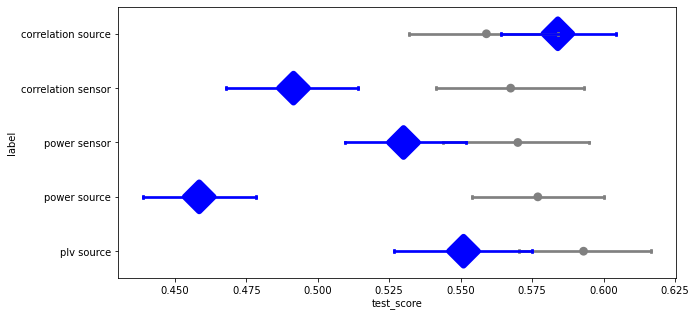

In [7]:
# plot model performance against chance level
import seaborn as sns

import matplotlib.pyplot as plt

_, ax = plt.subplots(1, 1, figsize=(10, 5))

# plot chance
sns.pointplot(data=chance_scores, ax=ax,
              x='test_score', y='label',
              color='gray',
              capsize=0.03,
              join=False,
              orient='h', label='chance')

# plot observed
sns.pointplot(data=grid_results, x='test_score', y='label',
              orient='h',
              ax=ax, label='power source',
              scale=3,
              cmap='viridis',
              capsize=0.03,
              join=False,
              color='blue',
              markers='D')

plt.show()